We start by adding the necessary folders to the current working path.

In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FTLE folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE2D")

# Overview

In the following notebook we compute the Finite Time Lyapunov Exponent ($ \mathrm{FTLE} $) on a 2-D homogeneous, isotropic turbulence. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data/AVISO'.
2. Define computational parameters and data.
3. Define spatio-temporal domain.
4. Interpolate velocity from (discrete) gridded data.
5. $ \mathrm{FTLE} $:

    Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid.
    
    Compute $ \mathrm{FTLE} $ from maximum singular value $ \sigma_{max} $ of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ according to:
    
    \begin{equation}
        \mathrm{FTLE}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0}\log(\sigma_{max}(\mathbf{x}_0)) \label{eq: FTLE} \tag{1}
    \end{equation}
       
6. References

# Import data

# Importer des données

In [11]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u'] # array (NY, NX, NT)
V = mat_file['v'] # array (NY, NX, NT)
x = mat_file['x'] # array (NY, NX)
y = mat_file['y'] # array (NY, NX)
time_data = mat_file['t'] # array (1, NT)

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 10 # int

# Time resolution of data
dt_data = time_data[0, 1]-time_data[0,0] # float

# Periodic boundary conditions
periodic_x = False # bool
periodic_y = False # bool
periodic_t = False # bool
periodic = [periodic_x, periodic_y, periodic_t]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U[:,:,0]).astype(int) # array (NY, NX)

## Compute meshgrid of dataset
X, Y = np.meshgrid(x, y) # array (NY, NX), array (NY, NX)

## Resolution of meshgrid
dx_data = X[0,1]-X[0,0] # float
dy_data = Y[1,0]-Y[0,0] # float

delta = [dx_data, dy_data] # list (2, )

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 25 # float

# Time step-size (in days)
dt = 0.1 # float

# NOTE: For computing the backward trajectories: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# Longitudinal and latitudinal boundaries (in degrees)
xmin = -3.5 # float
xmax = 1.0 # float
ymin = -32.0 # float
ymax = -24.0 # float

# make sure that domain is part of the data domain.
assert np.min(X) <= xmin <= np.max(X), " xmin must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(X) <= xmax <= np.max(X), " xmax must be between "+f'{np.min(X)} and {np.max(X)}'
assert np.min(Y) <= ymin <= np.max(Y), " ymin must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(Y) <= ymax <= np.max(Y), " ymax must be between "+f'{np.min(Y)} and {np.max(Y)}'
assert np.min(time_data) <= t0 <= np.max(time_data), " t0 must be between "+f'{np.min(time_data)} and {np.max(time_data)}'
assert np.min(time_data) <= tN <= np.max(time_data), " tN must be between "+f'{np.min(time_data)} and {np.max(time_data)}'

# Spacing of meshgrid (in degrees)
dx = 0.02 # float
dy = 0.02 # float

x_domain = np.arange(xmin, xmax + dx, dx) # array (Nx, )
y_domain = np.arange(ymin, ymax + dy, dy) # array (Ny, )

X_domain, Y_domain = np.meshgrid(x_domain, y_domain) # array (Ny, Nx)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy] # list (2, )

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [5]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, method = "cubic")

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object

# $ \mathrm{FTLE} $

Next, we compute the $ \mathrm{FTLE} $ over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. From the maximum singular value of the gradient of the flow map we can then compute the $ \mathrm{FTLE} $.

In [12]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny, )
x0 = X_domain.ravel() # array (Nx*Ny,)
y0 = Y_domain.ravel() # array (Nx*Ny,)

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny)

def parallel_FTLE(x0_batch, y0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch]) # array (2, Nx*Ny)

    # Compute gradient of flow map
    gradFmap = gradient_flowmap(time, X0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) # array (Nt, 2, 2, Nx*Ny)

    # Extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # array (Nt, 2, 2, Nx*Ny)

    # Compute FTLE
    FTLE = [] # list (Nx*Ny,)
    for i in range(gradFmap_t0_tN.shape[2]):
        FTLE.append(_FTLE(gradFmap_t0_tN[:,:,i], lenT))
    
    return FTLE

(401, 226)
(90626,)


In [7]:
# compute FTLE
results = Parallel(n_jobs=Ncores, verbose = 50)(delayed(parallel_FTLE)(x0_batch[i], y0_batch[i]) for i in range(len(x0_batch)))

# Extract FTLE from results of parallel computing
FTLE = results[0]

for res in results[1:]:
    FTLE = np.append(FTLE, res)
    
# Reshape array from vectorized form to structured meshgrid
FTLE = FTLE.reshape((X_domain.shape[0], X_domain.shape[1])) # array (Ny, Nx)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  2.4min remaining:  9.6min
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  2.4min remaining:  5.7min
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:  2.5min remaining:  3.8min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:  2.5min remaining:  2.5min
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:  2.6min remaining:  1.7min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:  2.6min remaining:  1.1min
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:  2.6min remaining:   39.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  2.6min finished


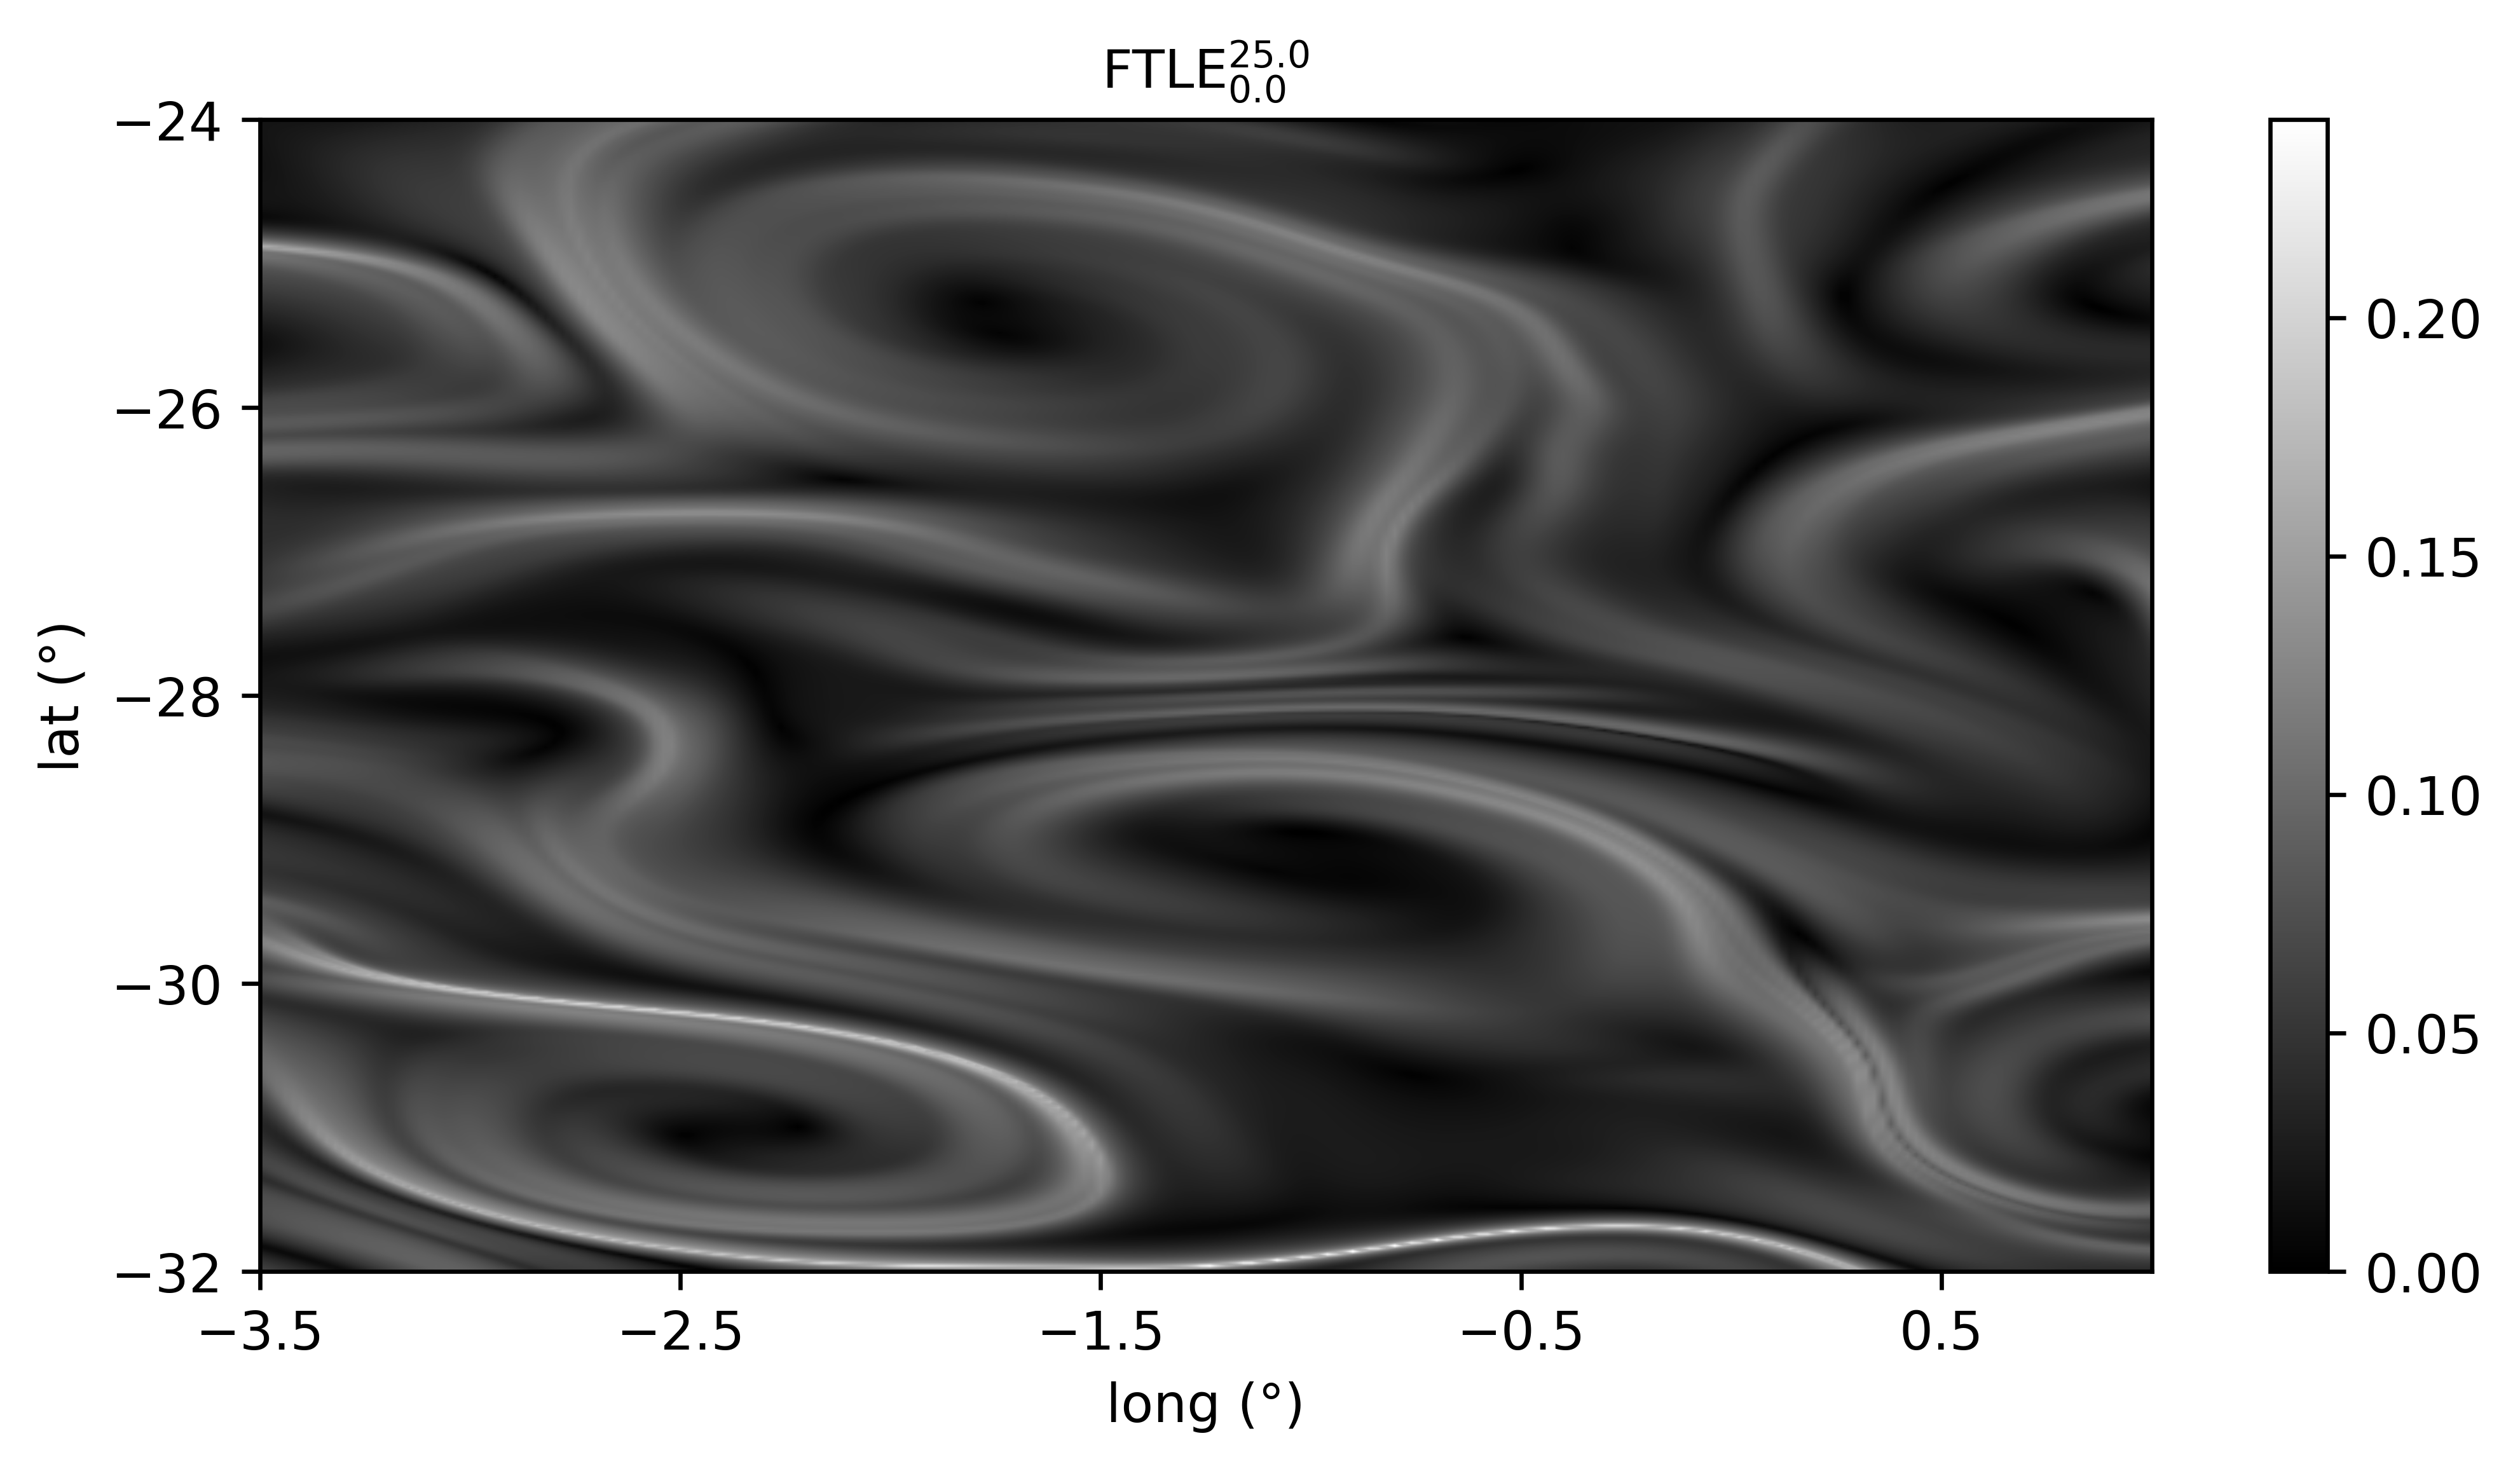

In [8]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize=(8, 4), dpi = 600)
ax = plt.axes()

# Contourplot of FTLE over meshgrid of initial conditions
cax = ax.contourf(X_domain, Y_domain, np.ma.masked_invalid(FTLE), cmap = "gist_gray", levels = 600)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax.set_yticks(np.arange(ymin, ymax+0.1, 2))

# Colorbar
cbar = fig.colorbar(cax, ticks = np.linspace(0, .4, 9))

# Title
ax.set_title(r'$ \mathrm{FTLE}$'+f'$_{{{np.around(time[0],2)}}}^{{{np.around(time[-1],2)}}}$', fontsize = 10)

plt.show()

The forward $ \mathrm{FTLE} $ field is plotted with respect to the initial position of the particles. Repelling LCS are visible as ridges in the forward $ \mathrm{FTLE} $ field, whereas trenches of $ \mathrm{FTLE} $ field signal parabolic (jet-type) LCSs. An analogous statement holds for attracting LCS and the backward $ \mathrm{FTLE} $ field. As a first approach, ridges of the $ \mathrm{FTLE} $ field can be extracted using simple thresholding. This should already provide a good hint to the location of hyperbolic features.

$ \mathrm{FTLE} $ ridges, however, are necessary but not sufficient conditions for hyperbolic LCS. Ridges of the $ \mathrm{FTLE} $ field have also been related to regions of high shear. As a consequence the $ \mathrm{FTLE} $ should only be considered as a first (and relatively rapid) approach for finding hyperbolic (repelling/attracting) LCS. More advanced methods such as the computation of the tensorlines associated to the eigenvalues of the Cauchy-Green strain tensor, should be used for a precise computation of hyperbolic LCS (see [HyperbolicLCS](../../HyperbolicLCS/Main/HyperbolicLCSAgulhas.ipynb)).[1, 2].

## Ridge extraction

We present a simple thresholding algorithm to extract ridges from the FTLE-field. The ridges denote initial repelling material lines at time $ t_0 $.

1. Extract points {x^*, y^*} which have an FTLE above $ FTLE_{threshold} $
2. for i < N:

    $ x^* \leftarrow x^* - \Delta s\dfrac{\nabla FTLE}{|\nabla FTLE|}\begin{pmatrix} 1 \\ 0 \end{pmatrix} $
    
    $ y^* \leftarrow y^* - \Delta s\dfrac{\nabla FTLE}{|\nabla FTLE|}\begin{pmatrix} 0 \\ 1 \end{pmatrix} $,
    
    where $ N $ is the number of iterations and $ \Delta s $ is a (small) parameter. 

In [9]:
# import interpolant
from scipy.interpolate import RectBivariateSpline

# import progress bar
from tqdm.notebook import tqdm

def Ridge_extraction(FTLE, FTLE_threshold, N, ds):
    
    Interpolant_FTLE = RectBivariateSpline(y_domain, x_domain, FTLE, kx=3, ky=3, s=0)

    x_ridges = X_domain[np.where(FTLE>FTLE_threshold)].ravel()
    y_ridges = Y_domain[np.where(FTLE>FTLE_threshold)].ravel()
    
    for s in tqdm(range(N)):
        
        # evaluate the gradient of the FTLE field
        grad_FTLE_x = (Interpolant_FTLE(y_ridges, x_ridges+dx, grid = False)-Interpolant_FTLE(y_ridges, x_ridges-dx, grid = False))/(2*dx)
        grad_FTLE_y = (Interpolant_FTLE(y_ridges+dy, x_ridges, grid = False)-Interpolant_FTLE(y_ridges-dy, x_ridges, grid = False))/(2*dy)
        grad_FTLE = np.sqrt(grad_FTLE_x**2+grad_FTLE_y**2)
        
        x_ridges = x_ridges - ds/(grad_FTLE)*grad_FTLE_x
        y_ridges = y_ridges - ds/(grad_FTLE)*grad_FTLE_y
        
    return x_ridges, y_ridges
    
x_ridges, y_ridges = Ridge_extraction(FTLE, FTLE_threshold = 0.11, N = 4000, ds = 10**(-5))

  0%|          | 0/4000 [00:00<?, ?it/s]

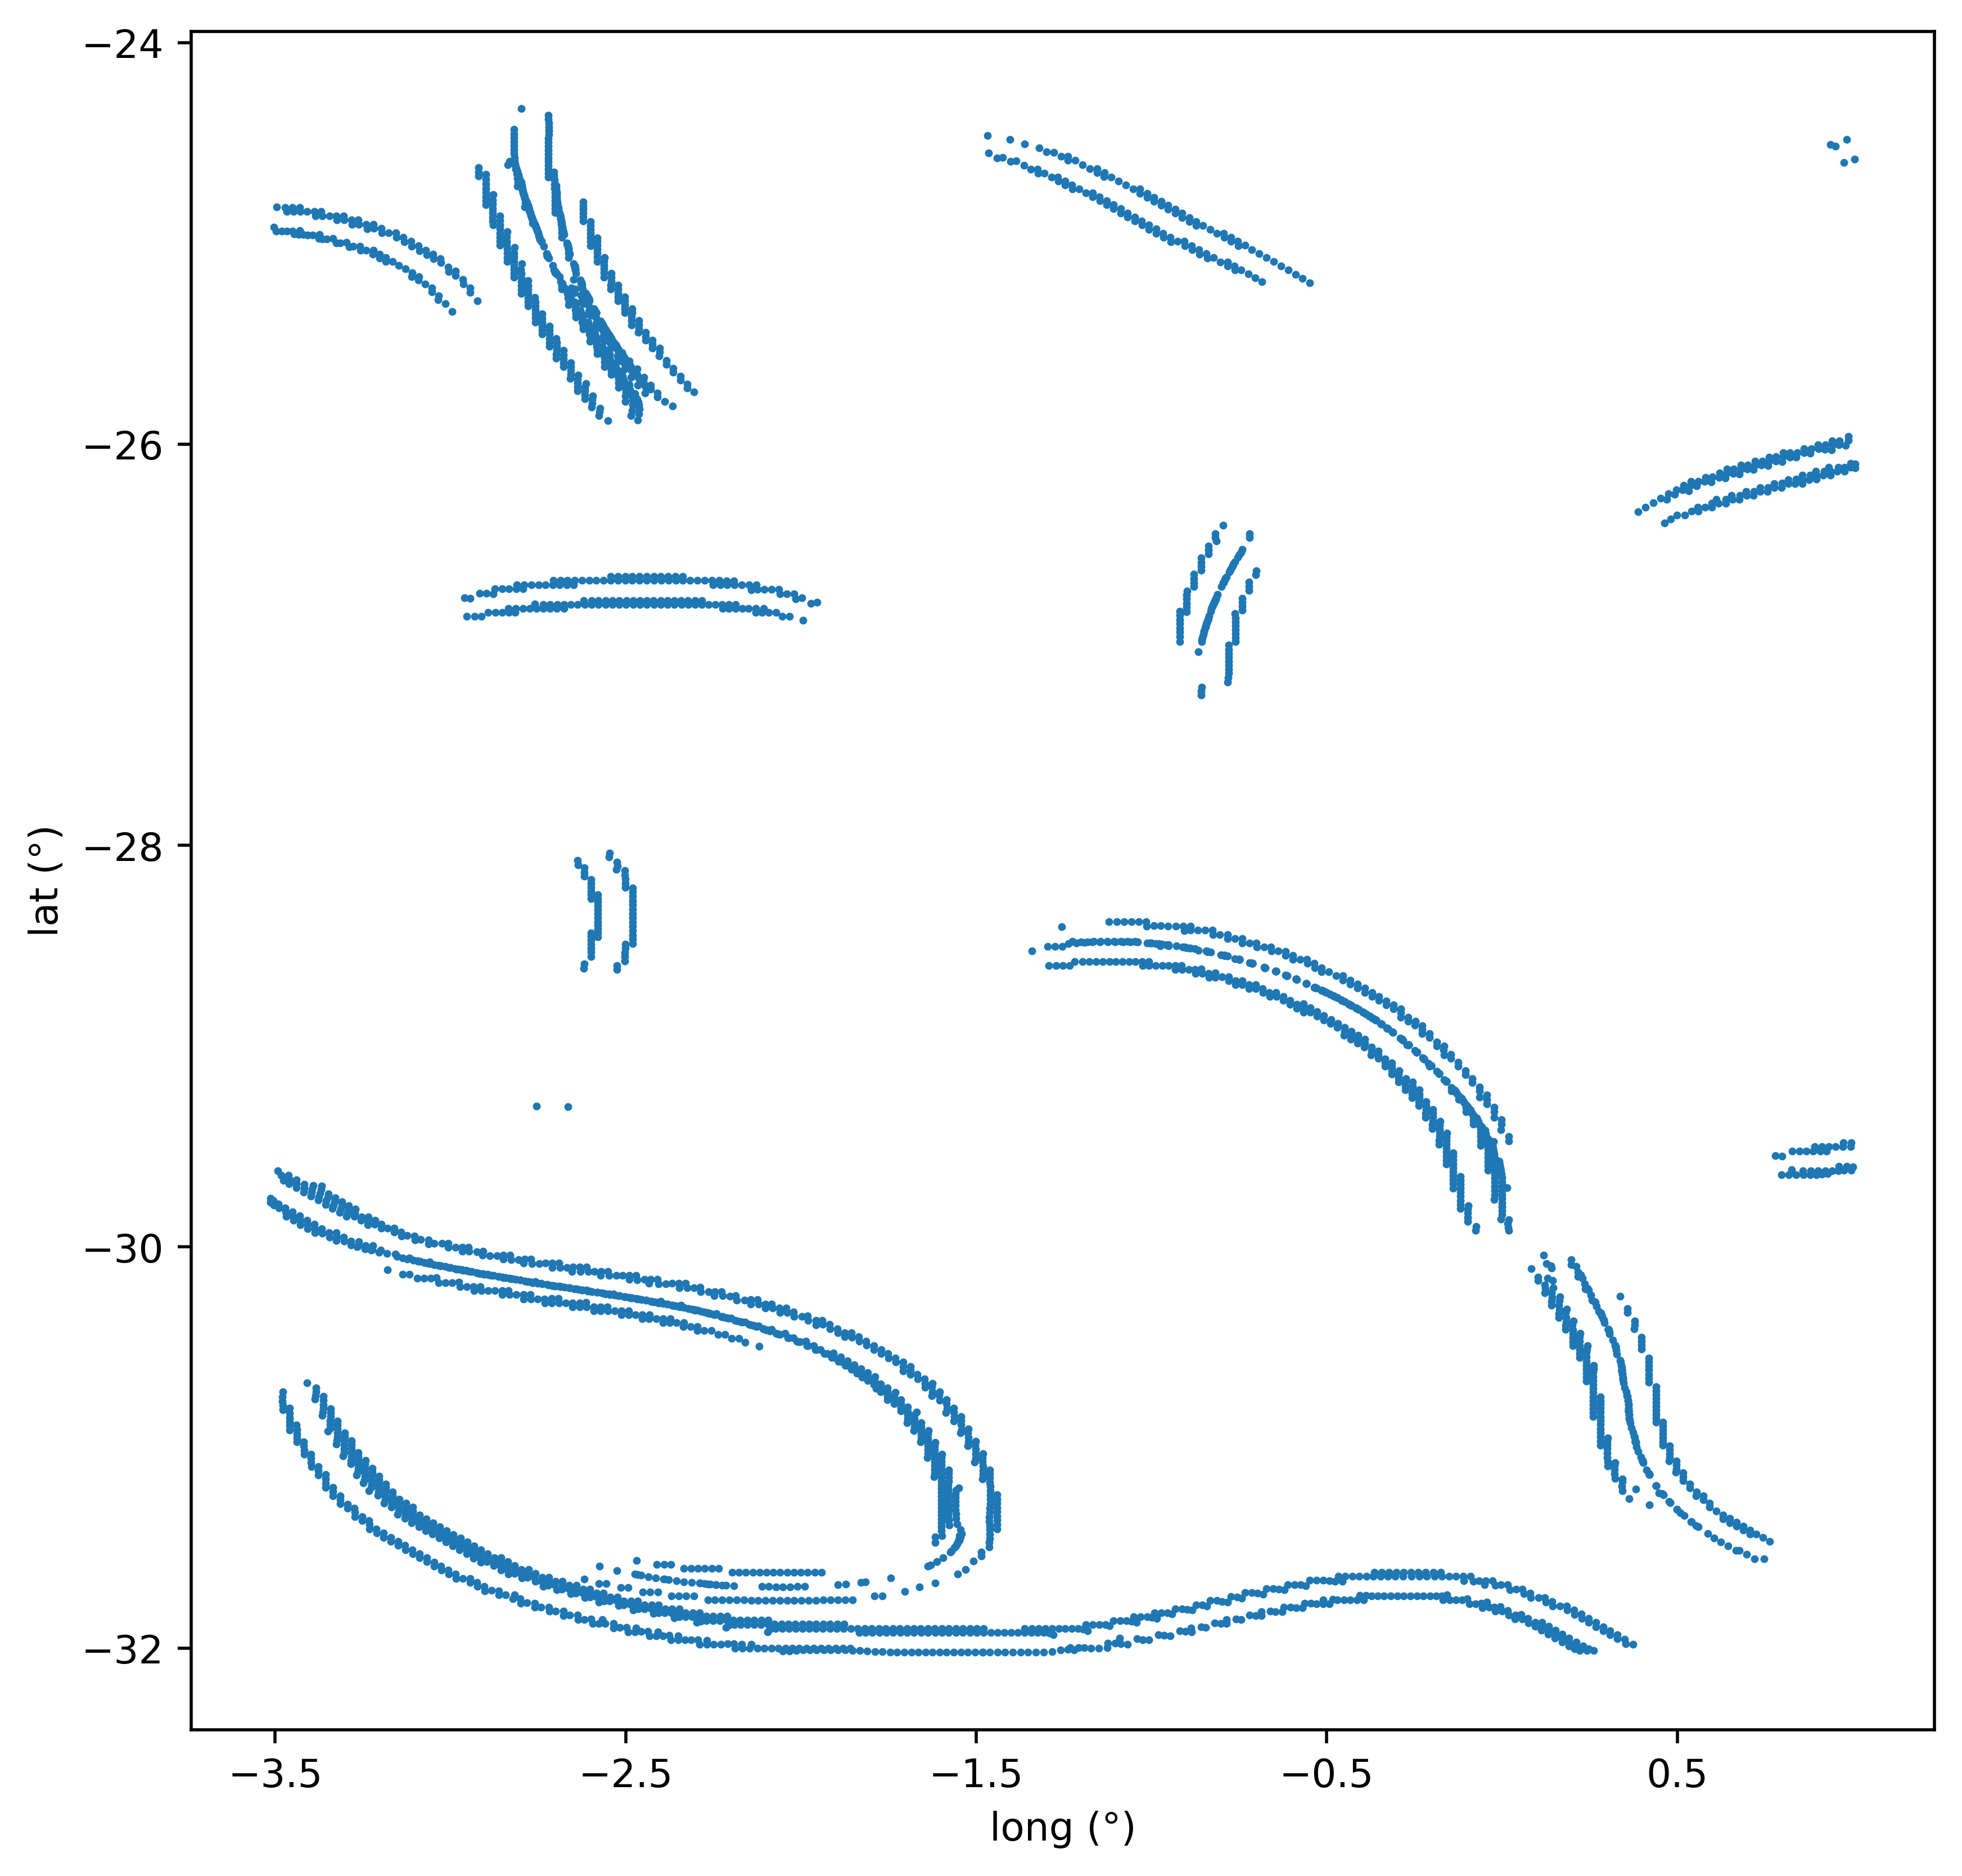

In [10]:
# Plot ridges = Repelling material lines at time t0

fig = plt.figure(figsize = (8,8), dpi = 500)
ax = plt.axes()

ax.scatter(x_ridges, y_ridges, s = 1)

# Axis Labels
ax.set_xlabel("long (°)", fontsize = 10)
ax.set_ylabel("lat (°)", fontsize = 10)

# Set axis ticks
ax.set_xticks(np.arange(xmin, xmax+0.1, 1))
ax.set_yticks(np.arange(ymin, ymax+0.1, 2))

plt.show()

# References

[1] Haller, G. (2015). Lagrangian coherent structures. Annual Review of Fluid Mechanics, 47, 137-162.

[2] Haller, G., & Sapsis, T. (2011). Lagrangian coherent structures and the smallest finite-time Lyapunov exponent. Chaos: An Interdisciplinary Journal of Nonlinear Science, 21(2), 023115.

[3] Notebook 5.1. in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.